# TP2 : MiniNN Notebook 

7 décembre 2016  
Adapté du TP de Gaétan Marceau-Caron

## Introduction

Au cours du TP1, nous avons étudié le modèle _Softmax_ (aussi connu sous le nom de MaxEnt) pour traiter le problème de classification probabiliste.
Le but était de présenter deux étapes importantes de l'entraînement: la {\it forward propagation} et la mise à jour des paramètres.
Le TP2 reprend le modèle Softmax dans un cadre plus général, celui des réseaux de neurones avec couches cachées.

Dans ce cadre, on peut considérer le modèle Softmax comme un "module" qui prend en entrée des "features", e.g. les pixels d'une image, et qui donne en sortie une loi de probabilité sur les étiquettes.
D'un point de vue computationnel, un réseau de neurones est composé de plusieurs modules, transformant simplement les features d'un espace à un autre en fonction des valeurs courantes des paramètres.
Ainsi, le but de l'entraînement est d'apprendre les transformations pertinentes, i.e., en modifiant les paramètres, qui permettront de réaliser la tâche associée au module de sortie. 
En augmentant le nombre de modules (mais aussi de fonctions non-linéaires), on augmente ainsi la complexité du modèle.
La thèse du {\it Deep Learning} nous dit que les modules près des données d'entrée doivent apprennent des features de bas niveau, e.g., filtre de Gabor pour l'image, alors que les modules près de la sortie apprennent des features de haut niveau, e.g., la probabilité qu'il y ait un chat dans l'image.
A priori, cette hiéarchie des features n'est pas imposée par le programmeur, mais apparaît naturellement lors de l'entraînement avec l'algorithme de backpropagation .

Le but du TP2 est de programmer les trois étapes essentielles à l'entraînement d'un réseau de neurones: la forward propagation, la backpropagation et la mise à jour des paramètres.
Ensuite, vous pouvez créer un test permettant de vérifier l'implémentation: le test des différences finies.
Finalement, vous pourrez comparer les performances de votre réseau de neurones avec celles de votre modèle Softmax de la semaine dernière.

## Objectifs : 
    1. Télécharger le TP2
    2. Implementer la fonction forward (nn ops.py:72)
    3. Implementer la fonction sigmoid et sa d ́eriv ́ee (nn ops.py:149)
    4. Implementer la fonction backward (nn ops.py:93)
    5. Implementer la fonction update (nn ops.py:123)
    6. Entrainer miniNN et obtenir une accuracy meilleur que le modèle softmax (de 0.92)


Et optionellemnt : 
    7. Implementer le test des diff ́erences finies (fd test.py)
    
La différence finie est une approximation de la dérivée partielle:
\begin{equation}
\frac{\partial l(w)}{\partial w_{i}} \approx \frac{l(w + \epsilon e_{i}) - l(w - \epsilon e_{i})}{2 \epsilon}
\end{equation}
où $l$ est une fonction à plusieurs variables avec ses dérivées partielles définies, $w$ est un vecteur, $w_{i}$ est sa $i$ème composante, $\epsilon$ est la longeur du pas et $e_{i}$ est le $i$ème vecteur de la base canonique de l'espace euclidien.

## Livrable

- __Date du livrable__: Le 16 décembre 2015  
- __Format du livrable__ un fichier compressé nommé "DL\_tp2\_prénom\_nom.zip" contenant le code et le résumé   
- __Dépôt__ à l'adresse _{thomas.schmitt@inria.fr}_ avec comme objet du message "DL\_tp2\_prénom\_nom".  
- __Description__  
Le livrable associé au TP2 doit contenir le code de MiniNN complété et accompagné d'un résumé de une à deux pages.
Le code doit s'exécuter avec la commande _python miniNN.py_ et afficher l'évolution de l'apprentissage (sortie par défaut du programme).  
( Ou bien être sous la forme d'un notebook. )

Le résumé doit être succinct et se focaliser uniquement sur les points essentiels reliés à l'entraînement des réseaux de neurones.
Ce document doit décrire les difficultés que vous avez rencontrées et, dans le cas échéant, les solutions utilisées pour les résoudre.
Vous pouvez aussi y décrire vos questions ouvertes et proposer une expérience sur MNIST afin d'y répondre.  




## Zone de Test 

### Load data and minibatch (as in miniNN.py)

In [1]:
# Pour ne pas reload le kernel quand un fichier .py change
%load_ext autoreload
%autoreload 2

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import copy, math, time, sys
import dataset_loader
from nn_ops import *

In [2]:
def frange(start, stop, step):
    
    i = start    
    while i < stop:
        yield i
        i += step
        
for i in frange(0.5, 1.0, 0.1):
    print(i)

0.5
0.6
0.7
0.8
0.9
1.0


In [3]:
my_lambda= [i for i in frange(0.0, 1.0, 0.1)]
my_lambda

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999]

In [4]:
%reload_ext autoreload
# Retrieve the arguments 
args = parseArgs_ipython(arch = [800]+[800], act_func = "ReLU", batch_size = 500, eta = .1, n_epoch = 100,regularization = "L1",dropout=True,
my_lambda=0.0001)                     #    my_lambda= [i for i in frange(0.0, 1.0, 0.1)])
# sigmoid, ReLU

In [5]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    print('download mnist data')
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz



In [6]:


# Fix the seed for the random generator
np.random.seed(seed=0)

#############################
### Dataset Handling
#############################

### Load the dataset
train_set, valid_set, test_set = dataset_loader.load_mnist()

### Define the dataset variables
n_training = train_set[0].shape[0]
n_feature = train_set[0].shape[1]
n_label = np.max(train_set[1])+1

#############################
### Neural Network parameters
#############################

### Activation function
act_func_name = args.act_func

### Network Architecture
nn_arch = np.array([n_feature] + args.arch + [n_label])

### Create the neural network
W,B,act_func,nb_params = initNetwork(nn_arch,act_func_name)

#############################
### Optimization parameters
#############################
eta = args.eta
regularization = args.regularization
batch_size = args.batch_size
n_batch = int(math.ceil(float(n_training)/batch_size))
n_epoch = args.n_epoch 
dropout=args.dropout
my_lambda=args.my_lambda

#############################
### Auxiliary variables
#############################
cumul_time = 0.

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

printDescription("Bprop", eta, nn_arch, act_func_name, batch_size, nb_params,regularization,dropout,my_lambda)





Description of the experiment
----------
Learning algorithm: Bprop
Initial step-size: 0.1
Network Architecture: [784 800 800  10]
Number of parameters: 1276810
Minibatch size: 500
Activation: ReLU
Regularization: L1
dropout: True
lambda: 0.0001
----------


In [7]:
nn_arch

array([784, 800, 800,  10])

In [8]:
### Mini-batch creation
j = 0
batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size, train_set, one_hot)
X_bacth = batch

In [9]:
### Forward propagation
Y,Yp = forward(act_func, W, B, batch)
Y[-1].shape

(10, 500)

In [10]:
assert Y[0].shape == (n_feature, batch_size)
assert Y[-1].shape == (10, batch_size)

In [11]:
assert Yp[0].shape == (nn_arch[1], batch_size)

In [12]:

### Compute the softmax
out = softmax(Y[-1])
out      
        

/root/anaconda2/envs/deepCourse/lib/python2.7/site-packages/numpy/core/_methods.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_sum(a, axis, dtype, out, keepdims)


array([[ 0.12880731,  0.11827404,  0.09253171, ...,  0.08833165,
         0.10769081,  0.09657219],
       [ 0.10429571,  0.11841295,  0.13972636, ...,  0.10554813,
         0.12997345,  0.09969981],
       [ 0.12025803,  0.1380775 ,  0.10400027, ...,  0.13241315,
         0.12516422,  0.11690929],
       ..., 
       [ 0.05387366,  0.06627942,  0.05773382, ...,  0.06517084,
         0.05875936,  0.0651225 ],
       [ 0.08918349,  0.06922461,  0.07371089, ...,  0.11224215,
         0.10385289,  0.10323163],
       [ 0.08643775,  0.08493223,  0.08491556, ...,  0.07885329,
         0.07387947,  0.06449472]])

In [13]:
assert out.shape == (nn_arch[-1], batch_size)

In [14]:
### Compute the gradient at the top layer
derror = out-one_hot_batch

        

In [15]:
assert derror.shape == (nn_arch[-1], batch_size)
W[1].shape

(800, 800)

In [16]:
### Backpropagation
gradB = backward(derror, W, Yp)

In [17]:
assert len(gradB) == len(nn_arch)-1
for gradw,dim in zip(gradB,nn_arch[1:]):
    gradw.shape = (dim,batch_size)

In [18]:
### Update the parameters
new_W, new_B = update(eta, batch_size, W, B, gradB, Y,regularization, my_lambda)


In [19]:
### Training accuracy
train_loss, train_accuracy = computeLoss(W, B, train_set[0], train_set[1], act_func) 

### Valid accuracy
valid_loss, valid_accuracy = computeLoss(W, B, valid_set[0], valid_set[1], act_func) 


## Training

0 21.660262 0.385787635034 0.91226 0.343846761372 0.9206 1
1 48.499459 0.285167768366 0.93376 0.260796624407 0.9396 1
2 70.045804 0.243851559306 0.9429 0.223411326799 0.9488 1
3 91.047379 0.223506945286 0.94696 0.208088288948 0.9516 1
4 112.016297 0.229037514961 0.94574 0.216624301255 0.9505 1
5 132.95799 0.195228960482 0.9534 0.184770092715 0.9591 1
6 153.843342 0.252994580754 0.93666 0.22240459879 0.9467 1
7 174.674925 0.180040267935 0.95754 0.177592232442 0.9618 1
8 195.477847 0.158455169423 0.96182 0.160339605253 0.9654 1
9 216.195685 0.156106782609 0.9627 0.160774305554 0.9652 1
10 237.439878 0.145033652587 0.96568 0.151357496678 0.9683 1
11 260.926952 0.130312617262 0.96876 0.137372721997 0.9709 1
12 287.606622 0.131219353961 0.96878 0.138753580819 0.9702 1
13 315.982275 0.136226265838 0.96884 0.148408307575 0.9683 1
14 339.25118 0.134132864674 0.96908 0.147971237153 0.9698 1
15 361.566537 1.74046061795 0.484 1.64656053024 0.4969 1
16 382.490296 0.177058796994 0.96002 0.180938982

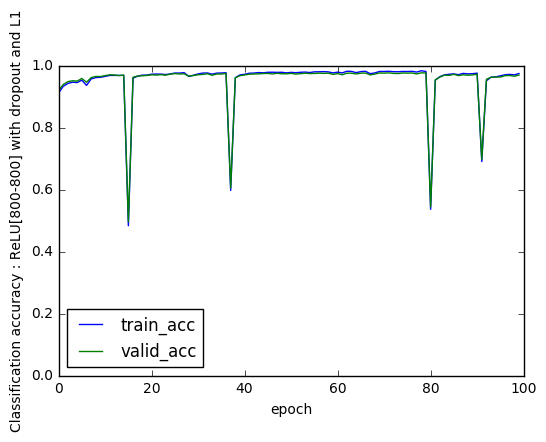

In [20]:
eta = 1
g_i = []
g_train_loss=[]
g_train_acc=[]
g_valid_loss=[]
g_valid_acc=[]
for i in range(n_epoch):
    for j in range(n_batch):

        ### Mini-batch creation
        batch, one_hot_batch, mini_batch_size = getMiniBatch(j, batch_size, train_set, one_hot)

        prev_time = time.clock()

        ### Forward propagation
        Y,Yp = forward(act_func, W, B, batch)

        ### Compute the softmax
        out = softmax(Y[-1])
        
        ### Compute the gradient at the top layer
        derror = out-one_hot_batch

        ### Backpropagation
        gradB = backward(derror, W, Yp)

        ### Update the parameters
        W, B = update(eta, batch_size, W, B, gradB, Y,regularization,my_lambda)

        curr_time = time.clock()
        cumul_time += curr_time - prev_time

    ### Training accuracy
    train_loss, train_accuracy = computeLoss(W, B, train_set[0], train_set[1], act_func) 

    ### Valid accuracy
    valid_loss, valid_accuracy = computeLoss(W, B, valid_set[0], valid_set[1], act_func) 

    result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_accuracy) + " " + str(valid_loss) + " " + str(valid_accuracy) + " " + str(eta)
    g_i = np.append(g_i, i)
    g_train_loss = np.append(g_train_loss, train_loss)
    g_train_acc = np.append(g_train_acc, train_accuracy)
    g_valid_loss = np.append(g_valid_loss, valid_loss)
    g_valid_acc = np.append(g_valid_acc, valid_accuracy)
    print(result_line)
    #plt.plot(j,label='train_acc')
    #plt.plot(j,label='valid_acc')
    #plt.xlabel("epoch")
    #plt.ylim([0.,1.])
    #plt.legend()


plt.plot(g_i,g_train_acc,label='train_acc')
plt.plot(g_i,g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification accuracy : ReLU[800-800] with dropout and L1")
plt.ylim([0.,1.])
plt.legend(loc='best')
plt.show()

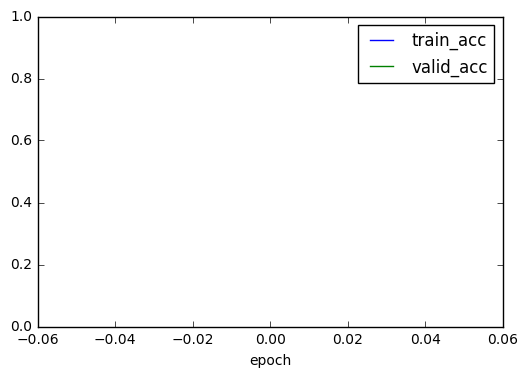

In [23]:
plt.plot(0,label='train_acc')
plt.plot(0,label='valid_acc')
plt.xlabel("epoch")
plt.ylim([0.,1.])
plt.legend()